# Finite Difference Testing
1. Testing that taking a trained energy model, `E=lr(X)`, can successfully predict forces: `[lr(X(r+dr)) - lr(X(r)))]/dr = -F(r)`
   * [SOAP](#soap-fd-forces)
   * [AniSOAP](#anisoap-fd-forces) 
2. Testing that the finite difference model `[X(r+dr) - X(r)]/dr` yields the same results as the analytical gradients.
   * [SOAP](#soap-fd)
   * [AniSOAP](#anisoap-fd) 

# SOAP Finite Difference Forces<a class="anchor" id="soap-fd-forces"></a>


In [1]:
from metatensor import TensorMap, TensorBlock
import metatensor
import numpy as np
from sklearn.linear_model import RidgeCV
from skmatter.preprocessing import StandardFlexibleScaler
def train_model(rep:TensorMap, e:np.ndarray, mode='soap'):
    """
    Train a linear model
    """
    if mode == 'soap':
        rep = rep.keys_to_samples("center_type")
        rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
        rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])
    elif mode == 'anisoap':
        rep = rep.keys_to_samples("types_center")
        rep = metatensor.mean_over_samples(rep, ["center", "types_center"])
    else:
        raise ValueError("`mode` nees to be 'soap' or 'anisoap'")
    X_unnorm = rep.block().values.squeeze()
    X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
    X = X_scaler.transform(X_unnorm)

    y_scaler = StandardFlexibleScaler(column_wise=True).fit(e)
    y = y_scaler.transform(e) 
    lr = RidgeCV(alphas=np.logspace(-8,2,12), cv=5)
    lr.fit(X,y)
    print(lr.score(X,y))
    return lr, X,X_scaler, y,y_scaler

In [2]:
def rep_to_energy(rep:TensorMap, lr:RidgeCV, mode='soap'):
    """
    Predict Energies using pretrained regressor lr
    """
    if mode == 'soap':
        rep = rep.keys_to_samples("center_type")
        rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
        rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])
    elif mode == 'anisoap':
        rep = rep.keys_to_samples("types_center")
        rep = metatensor.mean_over_samples(rep, ["center", "types_center"])
        X_unnorm = rep.block().values.squeeze()
    else:
        raise ValueError("`mode` nees to be 'soap' or 'anisoap'")
    X_unnorm = rep.block().values.squeeze()
    X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
    X = X_scaler.transform(X_unnorm)

    return lr.predict(X)


In [3]:
# Find the base soap descriptor, with no perturbations.
from ase.io import read
frames = read("./frames_1000.xyz", ":")
lmax=4
nmax=6

from featomic.calculators import SoapPowerSpectrum
HYPER_PARAMETERS = {
    "cutoff": {
        "radius": 5.0,
        "smoothing": {"type": "ShiftedCosine", "width": 0.5},
    },
    "density": {
        "type": "Gaussian",
        "width": 0.3,
    },
    "basis": {
        "type": "TensorProduct",
        "max_angular": lmax,
        "radial": {"type": "Gto", "max_radial": nmax},
    },
}

calculator = SoapPowerSpectrum(**HYPER_PARAMETERS)
base_rep = calculator.compute(frames, gradients=['positions'])

In [4]:
# Read Frames and associated energies and forces
from ase.io import read
frames = read("frames_1000.xyz", ":")
energies = []
forces = []
for frame in frames:
    energies.append(frame.get_total_energy())
    forces.append(frame.get_forces())
energies = np.array(energies).reshape(-1,1)
forces = np.asarray(forces)
print(energies.shape, forces.shape)

# Train base model and obtain scalers
lr, X,X_scaler, y,y_scaler = train_model(base_rep, energies, mode='soap')

(1000, 1) (1000, 12, 3)
0.9999919402983317


In [5]:
import signac 
from tqdm.auto import tqdm
project = signac.get_project()
delta = 0.01
rep_type = 'soap'
# for atom_i in range(12):    # One for each atom
#     for grad_dir in [0,1,2]:    # 'x' is 0, 'y' is 1, 'z' is 2
pred_forces_soap = np.zeros((1000, 12, 3))

for atom_i in tqdm(range(12)):    # One for each atom
    for grad_dir in [0,1,2]:    # 'x' is 0, 'y' is 1, 'z' is 2
        job = project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
        rep = metatensor.load(job.fn("rep.mts"))
        new_y = rep_to_energy(rep, lr,mode='soap')
        new_y = new_y.reshape(-1,1)
        new_e = y_scaler.inverse_transform(new_y)
        e = y_scaler.inverse_transform(y)    # same as original energies
        pred_forces_soap[:,atom_i,grad_dir] = (-(new_e - e)/delta).flatten()

/Users/alin62/miniconda3/envs/anisoap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 12/12 [03:38<00:00, 18.17s/it]


Text(0, 0.5, 'Predicted Forces SOAP Finite Diff')

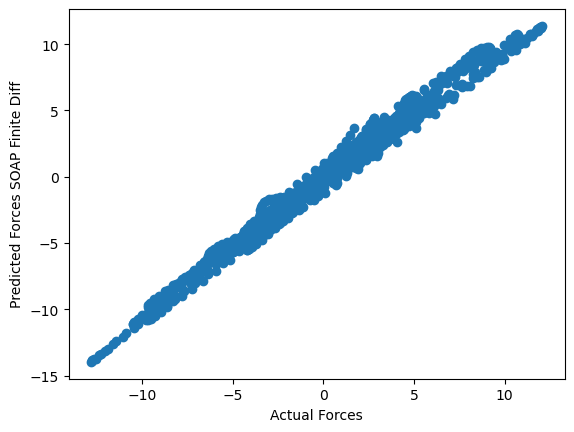

In [6]:
# Spot Check Parity Plots SOAP
atom_i=7
grad_dir=1
import matplotlib.pyplot as plt
plt.scatter(forces[:, atom_i, grad_dir], pred_forces_soap[:, atom_i, grad_dir])
plt.xlabel("Actual Forces")
plt.ylabel("Predicted Forces SOAP Finite Diff")

# AniSOAP Finite Difference Forces<a class="anchor" id="anisoap-fd-forces"></a>


In [7]:
# Now, do the exact same thing for AniSOAP. 
# Train the anisoap base rep
base_rep_anisoap = metatensor.load("base_rep_anisoap.mts")
lr, X,X_scaler, y,y_scaler = train_model(base_rep_anisoap, energies, mode='anisoap')

0.9995147064646669


In [8]:
import signac 
from tqdm.auto import tqdm
project = signac.get_project()
delta = 0.01
rep_type = 'anisoap'
# for atom_i in range(12):    # One for each atom
#     for grad_dir in [0,1,2]:    # 'x' is 0, 'y' is 1, 'z' is 2
pred_forces_anisoap = np.zeros((1000, 12, 3))

for atom_i in tqdm(range(12)):    # One for each atom
    for grad_dir in [0,1,2]:    # 'x' is 0, 'y' is 1, 'z' is 2
        job = project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
        rep = metatensor.load(job.fn("rep.mts"))
        new_y = rep_to_energy(rep, lr, mode=rep_type)
        new_y = new_y.reshape(-1,1)
        new_e = y_scaler.inverse_transform(new_y)
        e = y_scaler.inverse_transform(y)    # same as original energies
        pred_forces_anisoap[:,atom_i,grad_dir] = (-(new_e - e)/delta).flatten()

100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Text(0, 0.5, 'Predicted Forces AniSOAP Finite Diff')

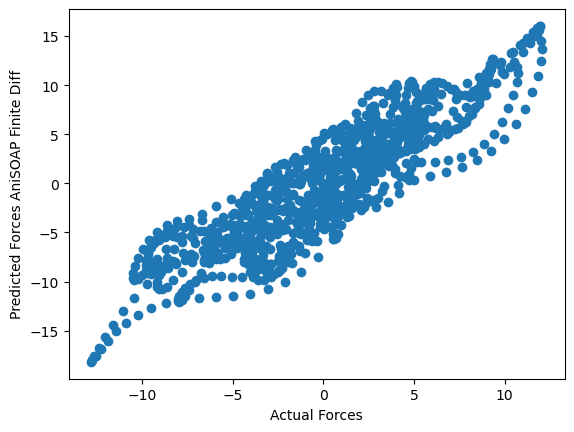

In [9]:
# Spot Check Parity Plots SOAP
atom_i=7
grad_dir=1
import matplotlib.pyplot as plt
plt.scatter(forces[:, atom_i, grad_dir], pred_forces_anisoap[:, atom_i, grad_dir])
plt.xlabel("Actual Forces")
plt.ylabel("Predicted Forces AniSOAP Finite Diff")

Finite Difference Parity Plots for AniSOAP look worse than SOAP's

# SOAP Finite Difference<a class="anchor" id="soap-fd"></a>
Extract the gradients from the SOAP base rep and compare with the finite-difference approximation

In [10]:
from metatensor import TensorMap, TensorBlock, Labels
from sklearn.linear_model import RidgeCV
from skmatter.preprocessing import StandardFlexibleScaler
import numpy as np
import signac

def filter_gradient_tensorblock(block:TensorBlock, atom_i:int, dim='sample'):
    # Return a new tensorblock with only atom_i, filtered by sample dimension
    if dim != 'sample':
        return ValueError("For now, dim must be 'sample'")
    mask = (block.samples.view("atom").values == atom_i).flatten()
    new_values = block.values[mask, :, :]
    new_samples = Labels(
        names=block.samples.names,
        values=block.samples.values[mask]
    )
    return TensorBlock(
        samples=new_samples,
        properties=block.properties,
        components=block.components,
        values=new_values
    )

def get_soap_model_atom_i(rep:TensorMap, atom_i:int, grad_dir:int, e:np.ndarray, f:np.ndarray, mode='soap'):
    if mode == 'soap':
        rep = rep.keys_to_samples("center_type")
        rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
        rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])
    elif mode == 'anisoap':
        rep = rep.keys_to_samples("types_center")
        rep = metatensor.mean_over_samples(rep, ["center", "types_center"])
        X_unnorm = rep.block().values.squeeze()
        X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
        X = X_scaler.transform(X_unnorm)
        return _, X,X_scaler, _
    else: 
        raise ValueError("`mode` needs to be 'soap' or 'anisoap")
    X_unnorm = rep.block().values.squeeze()
    X_grad_unnorm = filter_gradient_tensorblock(rep.block().gradient("positions"), atom_i).values[:,grad_dir,:]
    X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
    X = X_scaler.transform(X_unnorm)
    X_grad_scaler = StandardFlexibleScaler(column_wise=False).fit(X_grad_unnorm)
    X_grad = X_grad_scaler.transform(X_grad_unnorm)
    # Normalize the forces and energies. Note that y_ngradx is the negative of dy/dx
    y_scaler = StandardFlexibleScaler(column_wise=True).fit(e)
    y = y_scaler.transform(e) 
    # Use atom_i to extract the particular atom
    fx = f[:,atom_i,0].reshape(-1,1)
    print(fx.shape)
    y_ngradx_scaler = StandardFlexibleScaler(column_wise=True).fit(fx)
    y_ngradx = y_ngradx_scaler.transform(fx)
    print(y_ngradx.shape)
    from sklearn.linear_model import RidgeCV
    lr = RidgeCV(alphas=np.logspace(-8,2,12), cv=5)
    lr.fit(X, y)
    print(lr.score(X,y))
    print(lr.score(-X_grad, y_ngradx))
    return lr, X,X_scaler, X_grad

(1000, 1)
(1000, 1)
0.9940783064799119
-121.80747210390977
(1000, 1)
(1000, 1)
0.9999919402983317
-133.2959161079288


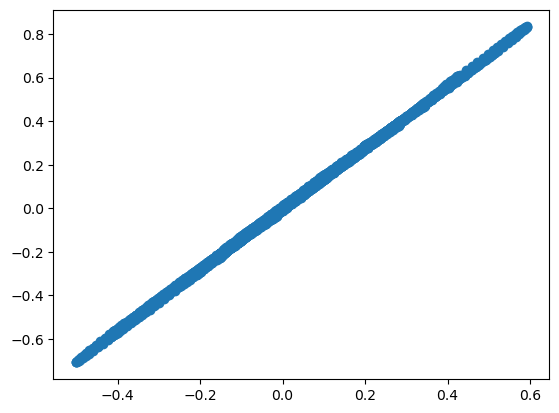

In [11]:
# Calculate SOAP finite differences: calculate the perturbed SOAP
import signac
import metatensor
import matplotlib.pyplot as plt
project = signac.get_project()
dir(project)
rep_type = 'soap'
delta=0.01
grad_dir = 0
atom_i = 0
job=project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
rep = metatensor.load(job.fn("rep.mts"))
_, new_X, new_X_scaler, _ = get_soap_model_atom_i(rep, atom_i, grad_dir, energies, forces)

# Calculate SOAP finite differences: calculate the original SOAP descriptor
base_rep = calculator.compute(frames, gradients=['positions'])
_, X, X_scaler, X_grad = get_soap_model_atom_i(base_rep, atom_i, grad_dir, energies, forces)

X_gradx_fd = (new_X - X) / delta
plt.scatter(X_grad.flatten(), X_gradx_fd.flatten())

We see that the finite difference code produces nearly identical gradients to the analytical gradients for SOAP.

# AniSOAP Finite Difference<a class="anchor" id="anisoap-fd"></a>
Extract the gradients from the AniSOAP base rep and compare with the finite-difference approximation

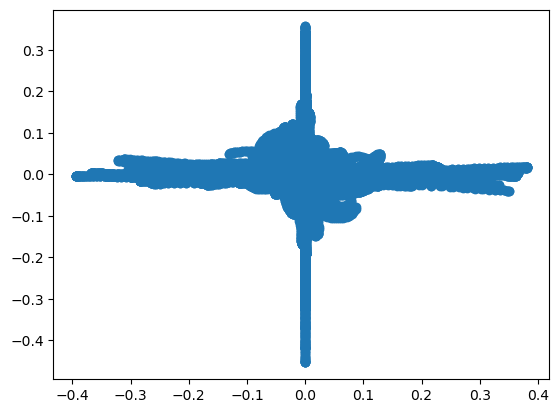

In [12]:
# Calculate AniSOAP finite differences: Extract the perturbed AniSOAP Data matrix
import signac
import metatensor
project = signac.get_project()
dir(project)
rep_type = 'anisoap'
delta=0.01
grad_dir = 0
atom_i = 0
job=project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
rep = metatensor.load(job.fn("rep.mts"))

rep = rep.keys_to_samples("types_center")
rep = metatensor.mean_over_samples(rep, ["center", "types_center"])
X_unnorm = rep.block().values.squeeze()
X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
new_X = X_scaler.transform(X_unnorm)

# Calculate AniSOAP finite differences: calculate the original AniSOAP descriptor
base_rep = metatensor.load("base_rep_anisoap.mts")
base_rep = base_rep.keys_to_samples("types_center")
base_rep = metatensor.mean_over_samples(base_rep, ["center", "types_center"])
X_unnorm = base_rep.block().values.squeeze()
X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
X= X_scaler.transform(X_unnorm)

X_gradx_fd = (new_X - X) / delta

X_grad_unnorm = filter_gradient_tensorblock(base_rep.block().gradient("positions"), atom_i).values[:,grad_dir,:].squeeze()
X_grad_scaler = StandardFlexibleScaler(column_wise=False).fit(X_grad_unnorm)
X_grad = X_grad_scaler.transform(X_grad_unnorm)
plt.scatter(X_grad.flatten(), X_gradx_fd.flatten())

The parity plot above shows that there is a bug in the anisoap gradient code. Coincidentally, looks like one of the pca clusters we saw.

# SCRATCH BELOW

In [11]:
base_rep.block()

TensorBlock
    samples (1000): ['system']
    components (1): ['spherical_harmonics_m']
    properties (720): ['neighbor_types_1_a', 'n_1_a', 'k_2', 'neighbor_types_1_b', 'n_1_b', 'l_2']
    gradients: ['positions']

In [12]:
rep.block()

TensorBlock
    samples (1000): ['system']
    components (1): ['spherical_harmonics_m']
    properties (720): ['neighbor_types_1_a', 'n_1_a', 'k_2', 'neighbor_types_1_b', 'n_1_b', 'l_2']
    gradients: None

In [ ]:
# Spot Check Finite Difference
X_gradx_fd

In [56]:
forces[0:5, 11, 2]

array([0.        , 0.11504592, 0.2406672 , 0.376524  , 0.51715872])

In [55]:
ftest = -(new_e-e)/delta
ftest

array([[ -0.38622651],
       [ -0.17391678],
       [  0.06529719],
       [  0.32421483],
       [  0.62194743],
       [  0.947143  ],
       [  1.23915175],
       [  1.54566506],
       [  1.85511041],
       [  2.12891274],
       [  2.39872952],
       [  2.64099032],
       [  2.89237909],
       [  3.12686895],
       [  3.29309492],
       [  3.48902764],
       [  3.62052783],
       [  3.76985319],
       [  3.89556966],
       [  4.01567159],
       [  4.10972341],
       [  4.21095064],
       [  4.25709152],
       [  4.33501284],
       [  4.35390931],
       [  4.37567452],
       [  4.38048938],
       [  4.32552944],
       [  4.28064133],
       [  4.20652764],
       [  4.12500482],
       [  4.05768096],
       [  3.99547817],
       [  3.89168343],
       [  3.83594664],
       [  3.80081852],
       [  3.74832265],
       [  3.7113774 ],
       [  3.72001918],
       [  3.74070999],
       [  3.73658574],
       [  3.72841592],
       [  3.73299337],
       [  3

In [43]:
forces

array([[[ 0.00000000e+00, -3.82596480e+00, -0.00000000e+00],
        [-3.24928800e+00, -1.94189760e+00, -0.00000000e+00],
        [-3.24928800e+00,  1.94189760e+00,  0.00000000e+00],
        ...,
        [-0.00000000e+00, -6.04474560e+00,  0.00000000e+00],
        [-5.21874720e+00, -3.01262400e+00,  0.00000000e+00],
        [-5.21874720e+00,  3.01262400e+00,  0.00000000e+00]],

       [[ 1.11068640e+00, -3.48842880e+00,  5.64674400e-01],
        [-2.45894400e+00, -1.13021712e+00,  1.18552610e-01],
        [-2.27453760e+00,  1.22346140e-01, -3.22531200e-01],
        ...,
        [ 1.57695800e-02, -7.33620960e+00,  1.13925170e-01],
        [-5.80842720e+00, -3.25497600e+00,  1.29719230e-01],
        [-3.06809280e+00,  1.98758880e+00,  1.15045920e-01]],

       [[ 2.24255520e+00, -3.04914240e+00,  1.14397344e+00],
        [-1.59134400e+00, -2.70688320e-01,  2.42511840e-01],
        [-1.24654032e+00, -1.75278240e+00, -6.68413440e-01],
        ...,
        [ 3.15537100e-02, -8.54546400e+00,

In [42]:
pred_forces

array([[[ -2.0202712 ,  -6.24834628,  -0.57155184],
        [ -4.58242848,  -4.88803024,   1.18815084],
        [ -4.66564074,  -2.11131573,   1.06638497],
        ...,
        [ -1.19217368,  -9.65469801,  -0.89200665],
        [ -7.07742687,  -5.49560915,  -1.24430211],
        [ -8.28647054,   2.2026154 ,  -0.38622651]],

       [[ -0.6548732 ,  -5.80432055,   0.08349524],
        [ -3.67472361,  -3.80319009,   1.41351592],
        [ -3.49092153,  -3.92556421,   0.82128183],
        ...,
        [ -1.09803705, -10.93390617,  -0.6710821 ],
        [ -7.5955664 ,  -5.65757962,  -1.01474323],
        [ -5.99403905,   1.30675212,  -0.17391678]],

       [[  0.76287092,  -5.21224895,   0.77857197],
        [ -2.67608508,  -2.65764669,   1.66406068],
        [ -2.24777536,  -5.77715992,   0.56339283],
        ...,
        [ -0.98778754, -12.12108166,  -0.44097154],
        [ -8.0213247 ,  -5.75679087,  -0.76919966],
        [ -3.61100921,   0.39545059,   0.06529719]],

       ...,

      

In [37]:
pred_forces

array([[[ 0.        , -6.24834628,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        , -5.80432055,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        , -5.21224895,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.        , -6.89376063,  0.        ],
        [ 0

In [14]:
frames[0].arrays

{'numbers': array([6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]),
 'positions': array([[ 0.    ,  1.397 ,  0.    ],
        [ 1.2098,  0.6985,  0.    ],
        [ 1.2098, -0.6985,  0.    ],
        [ 0.    , -1.397 ,  0.    ],
        [-1.2098, -0.6985,  0.    ],
        [-1.2098,  0.6985,  0.    ],
        [ 0.    ,  2.481 ,  0.    ],
        [ 2.1486,  1.2405,  0.    ],
        [ 2.1486, -1.2405,  0.    ],
        [ 0.    , -2.481 ,  0.    ],
        [-2.1486, -1.2405,  0.    ],
        [-2.1486,  1.2405,  0.    ]]),
 'c_diameter1': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'c_diameter2': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'c_diameter3': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'c_q': array([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0

In [77]:
# Create SOAP Model
from metatensor import TensorMap, TensorBlock, Labels
from sklearn.linear_model import RidgeCV
from skmatter.preprocessing import StandardFlexibleScaler
import numpy as np
import signac
def extract_soap(job):
    """
    Get normalized SOAP representations and normalized SOAP gradient representations
    """
    rep=metatensor.load(job.fn("rep.mts"))
    
def filter_gradient_tensorblock(block:TensorBlock, atom_i:int, dim='sample'):
    # Return a new tensorblock with only atom_i, filtered by sample dimension
    if dim != 'sample':
        return ValueError("For now, dim must be 'sample'")
    mask = (block.samples.view("atom").values == atom_i).flatten()
    new_values = block.values[mask, :, :]
    new_samples = Labels(
        names=block.samples.names,
        values=block.samples.values[mask]
    )
    return TensorBlock(
        samples=new_samples,
        properties=block.properties,
        components=block.components,
        values=new_values
    )

def get_soap_model_atom_i(rep:TensorMap, atom_i:int, grad_dir:int, e:np.ndarray, f:np.ndarray):
    rep = rep.keys_to_samples("center_type")
    rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
    rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])
    X_unnorm = rep.block().values.squeeze()
    X_grad_unnorm = filter_gradient_tensorblock(rep.block().gradient("positions"), atom_i).values[:,grad_dir,:]
    X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
    X = X_scaler.transform(X_unnorm)
    X_grad_scaler = StandardFlexibleScaler(column_wise=False).fit(X_grad_unnorm)
    X_grad = X_grad_scaler.transform(X_grad_unnorm)
    # Normalize the forces and energies. Note that y_ngradx is the negative of dy/dx
    y_scaler = StandardFlexibleScaler(column_wise=True).fit(e)
    y = y_scaler.transform(e) 
    # Use atom_i to extract the particular atom
    fx = f[:,atom_i,0].reshape(-1,1)
    print(fx.shape)
    y_ngradx_scaler = StandardFlexibleScaler(column_wise=True).fit(fx)
    y_ngradx = y_ngradx_scaler.transform(fx)
    print(y_ngradx.shape)
    from sklearn.linear_model import RidgeCV
    lr = RidgeCV(alphas=np.logspace(-8,2,12), cv=5)
    lr.fit(X, y)
    print(lr.score(X,y))
    print(lr.score(-X_grad, y_ngradx))
    return lr, X,X_scaler, X_grad

<!-- # AniSOAP Finite Difference Forces<a class="anchor" id="anisoap-fd-forces"></a> -->

In [ ]:
# Find the base anisoap descriptor, no perturbation
from pathlib import Path
from ase.io import read
if (Path("base_rep_anisoap.mts").exists()):
    base_rep_anisoap = metatensor.load("base_rep_anisoap.mts")
else:
    lmax=4
    nmax=5
    frames = read("frames_1000.xyz", ":")
    for frame in frames:
        frame.arrays["c_diameter[1]"] = frame.arrays.pop("c_diameter1")
        frame.arrays["c_diameter[2]"] = frame.arrays.pop("c_diameter2")
        frame.arrays["c_diameter[3]"] = frame.arrays.pop("c_diameter3")
    AniSOAP_HYPERS = {
            "max_angular": lmax,
            "max_radial": nmax,
            "radial_basis_name": "gto",
            "rotation_type": "quaternion",
            "rotation_key": "c_q",
            "cutoff_radius": 7.0,
            "radial_gaussian_width": 1.5,
            "basis_rcond": 1e-8,
            "basis_tol": 1e-4,
        }
    from anisoap.representations import EllipsoidalDensityProjection
    calculator = EllipsoidalDensityProjection(**AniSOAP_HYPERS)
    mvg_coeffs = calculator.transform(frames, show_progress=True, normalize=True, rust_moments=False, compute_gradients=True)
    from anisoap.utils.metatensor_utils import (
        ClebschGordanReal,
        cg_combine,
        standardize_keys,
    )
    import metatensor

    mvg_nu1 = standardize_keys(mvg_coeffs)  # standardize the metadata naming schemes
    # Create an object that stores Clebsch-Gordan coefficients for a certain lmax:
    mycg = ClebschGordanReal(lmax)

    # Combines the mvg_nu1 with itself using the Clebsch-Gordan coefficients.
    # This combines the angular and radial components of the sample.
    mvg_nu2 = cg_combine(
        mvg_nu1,
        mvg_nu1,
        clebsch_gordan=mycg,
        lcut=0,
        other_keys_match=["types_center"],
    )
    base_rep_anisoap = mvg_nu2
    metatensor.save("base_rep_anisoap.mts", base_rep_anisoap)
    # Takes about 17 minutes with lmax=4,nmax=5

/Users/alin62/miniconda3/envs/anisoap/lib/python3.11/site-packages/anisoap/representations/ellipsoidal_density_projection.py:636: UserWarning: In quaternion mode, quaternions are assumed to be in (w,x,y,z) format.
  warnings.warn(
Computing neighborlist: 100%|██████████| 1000/1000 [00:00<00:00, 12699.43it/s]


In [ ]:
# Get model for atom_i=0, grad_dir=0
atom_i=0
grad_dir=0
lr_base, X,X_scaler, X_gradx,X_gradx_scaler, y,y_scaler, y_ngradx,y_ngradx_scaler, rep = get_soap_model_atom_i(base_rep, atom_i, grad_dir, energies, forces)

(1000, 1)
(1000, 1)
0.9999919402983317
-133.29591610792895


In [67]:
metatensor.save("rep.mts", base_rep)

In [69]:
rep_type = 'anisoap'
delta=0.01
grad_dir = 0
atom_i = 0
job=project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
rep = metatensor.load(job.fn("rep.mts"))


In [71]:
rep.block(0)

TensorBlock
    samples (6000): ['system', 'center']
    components (1): ['spherical_harmonics_m']
    properties (720): ['neighbor_types_1_a', 'n_1_a', 'k_2', 'neighbor_types_1_b', 'n_1_b', 'l_2']
    gradients: None

In [57]:
X_gradx_fd.shape

(1000, 735)

In [49]:
new_y = lr_base.predict(X)
new_y = new_y.reshape(-1,1)
new_e = y_scaler.inverse_transform(new_y)
forces_finite_diff = -(new_e-energies)/delta
forces_finite_diff

array([[ -2.0202712 ],
       [ -0.6548732 ],
       [  0.76287092],
       [  2.19331099],
       [  3.63222666],
       [  5.07822788],
       [  6.47103552],
       [  7.84899026],
       [  9.18652932],
       [ 10.44304649],
       [ 11.68658578],
       [ 12.89308905],
       [ 14.07900936],
       [ 15.21135684],
       [ 16.23893056],
       [ 17.23031729],
       [ 18.09651962],
       [ 18.94474686],
       [ 19.6919278 ],
       [ 20.37295425],
       [ 21.00119747],
       [ 21.56813437],
       [ 22.03969596],
       [ 22.49084545],
       [ 22.83347521],
       [ 23.13170877],
       [ 23.36644349],
       [ 23.49104407],
       [ 23.5632943 ],
       [ 23.56136881],
       [ 23.4871997 ],
       [ 23.37228766],
       [ 23.20742376],
       [ 22.94601378],
       [ 22.66374358],
       [ 22.35741098],
       [ 21.96875102],
       [ 21.52668074],
       [ 21.06678227],
       [ 20.57167049],
       [ 19.98036805],
       [ 19.31003069],
       [ 18.59547625],
       [ 17

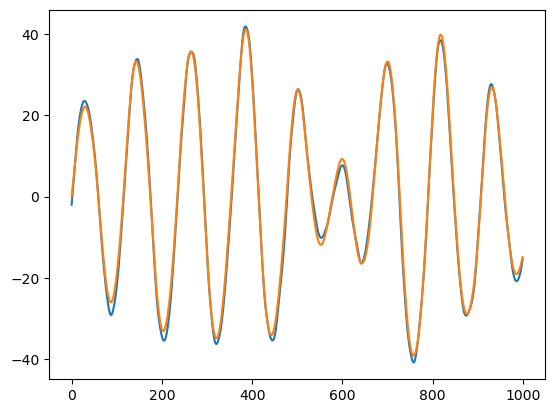

In [51]:
import matplotlib.pyplot as plt
plt.plot(forces_finite_diff)
plt.plot(forces[:,atom_i,0].reshape(-1,1))

In [7]:
rep = rep.keys_to_samples("center_type")
rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])

In [8]:
rep.block(0).gradient("positions")

Gradient TensorBlock ('positions')
    samples (12000): ['sample', 'system', 'atom']
    components (3): ['xyz']
    properties (735): ['neighbor_1_type', 'neighbor_2_type', 'l', 'n_1', 'n_2']
    gradients: None

In [9]:
reduced_block = filter_gradient_tensorblock(rep.block(0).gradient("positions"), atom_i=0)
reduced_block

TensorBlock
    samples (1000): ['sample', 'system', 'atom']
    components (3): ['xyz']
    properties (735): ['neighbor_1_type', 'neighbor_2_type', 'l', 'n_1', 'n_2']
    gradients: None

In [19]:
reduced_block.components

[Labels(
     xyz
      0
      1
      2
 )]

In [8]:
rep = rep.keys_to_samples("center_type")
rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])

In [24]:
mask = rep.block(0).gradient("positions").samples.view("atom").values == 0
rep.block(0).gradient("positions").samples.names

['sample', 'system', 'atom']